In [21]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from src.models.train_model import train_svm
from tqdm import tqdm
from src.data.dataset_loaders import DatasetLoader, DOTADatasetLoader
from src.features.pipelines import RawImageToFeatures
from src.data.image_loaders import DOTAFixedSizeImageLoader
from src.models.detectors import SliderProbDetector, Detector
from src.data.sliders import SlidingWindow
from src.features.descriptors import HOGDescriptor, LBPDescriptor
import matplotlib.pyplot as plt
from src.models.classifiers import ProbSVMModelWrapper
from typing import Tuple
from copy import deepcopy

# DOTA
# SVM Experiment

### Data loading

In [3]:
DATA_PATH = '../../../data/processed/dota/svm/data_svm_1.pickle'

In [4]:
with open(DATA_PATH, 'rb') as f:
    data = pickle.load(f)

### SVM training

In [11]:
SAVE_MODEL_PATH = '../../../models/svm/dota_svm_1.pickle'

In [5]:
model, report = train_svm(data, test_size=0.2, probability=True)

In [6]:
print(report)

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1190
           1       0.91      0.91      0.91      1252

    accuracy                           0.91      2442
   macro avg       0.91      0.91      0.91      2442
weighted avg       0.91      0.91      0.91      2442



In [12]:
with open(SAVE_MODEL_PATH, 'wb') as f:
    pickle.dump(model, f)

### Validation

In [18]:
def validate_model(
    dataset_loader: DatasetLoader,
    input_folder_filepath: str,
    images_files_types: Tuple[str],
    annotations_files_types: Tuple[str],
    detector: Detector,
    workers: int = 0
):

    images = dataset_loader.load_dataset(
        input_folder_filepath,
        images_files_types,
        annotations_files_types,
        False
    )

    processed_images = []

    for image in tqdm(images):
        processed_images.append(
            detector(deepcopy(image), workers)
        )

    return processed_images

In [52]:
BND_BOX_SIZE = (50, 50)
MIN_SIDE_OF_BOX = 40

dataset_loader = DOTADatasetLoader(
    image_loader=DOTAFixedSizeImageLoader(
        bnd_box_size=BND_BOX_SIZE,
        min_side_of_box=MIN_SIDE_OF_BOX
    )
)

process_pipeline = RawImageToFeatures(
    processors=[],
    descriptors=[
        HOGDescriptor(
            orientations = 9,
            cells_per_block = (2, 2),
            pixels_per_cell = (4, 4),
            multichannel = True,
            visualize = True
        ),
        LBPDescriptor(
            bins = 256,
            range = (0, 256)
        )
    ]
)

sliding_window = SlidingWindow(
    step_size=20,
    window_size=BND_BOX_SIZE
)

slider_detector = SliderProbDetector(
    sliding_window=sliding_window,
    process_pipeline=process_pipeline,
    classifier=ProbSVMModelWrapper(model),
    treshold=0.9,
    nms_overlap=0.4
)

In [53]:
processed_images = validate_model(
    dataset_loader=dataset_loader,
    input_folder_filepath='../../../data/raw/dota/val_dev',
    images_files_types=('jpg', 'JPG', 'png'),
    annotations_files_types=('txt',),
    detector=slider_detector,
    workers=7
)

 20%|██        | 1/5 [01:44<06:59, 104.99s/it]169
Overlap is 0.04652056901191849
Overlap is 0.36947327950788156
Overlap is 0.04652056901191849
Overlap is 0.04652056901191849
Overlap is 0.04652056901191849
Overlap is 0.36947327950788156
Overlap is 0.36947327950788156
Overlap is 0.04652056901191849
Overlap is 0.04652056901191849
Overlap is 0.36947327950788156
Overlap is 0.04652056901191849
Overlap is 0.04652056901191849
Overlap is 0.36947327950788156
Overlap is 0.36947327950788156
Overlap is 0.36947327950788156
Overlap is 0.04652056901191849
Overlap is 0.36947327950788156
Overlap is 0.36947327950788156
Overlap is 0.1311034217608612
Overlap is 0.04652056901191849
Overlap is 0.36947327950788156
Overlap is 0.36947327950788156
Overlap is 0.1311034217608612
Overlap is 0.04652056901191849
Overlap is 0.04652056901191849
Overlap is 0.04652056901191849
Overlap is 0.04652056901191849
Overlap is 0.1311034217608612
Overlap is 0.04652056901191849
Overlap is 0.36947327950788156
Overlap is 0.0465205690

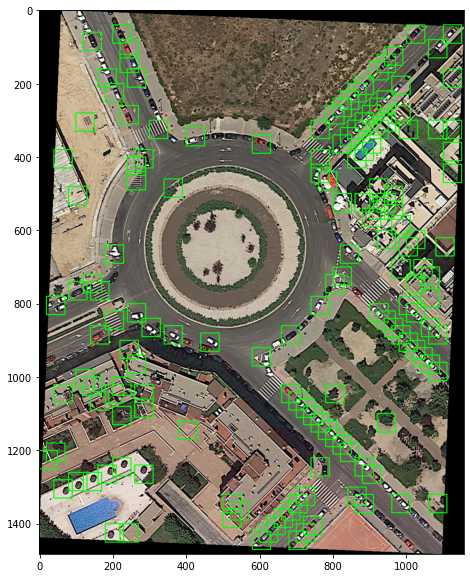

In [54]:
plt.figure(figsize=(20,10))
plt.imshow(processed_images[0][0])

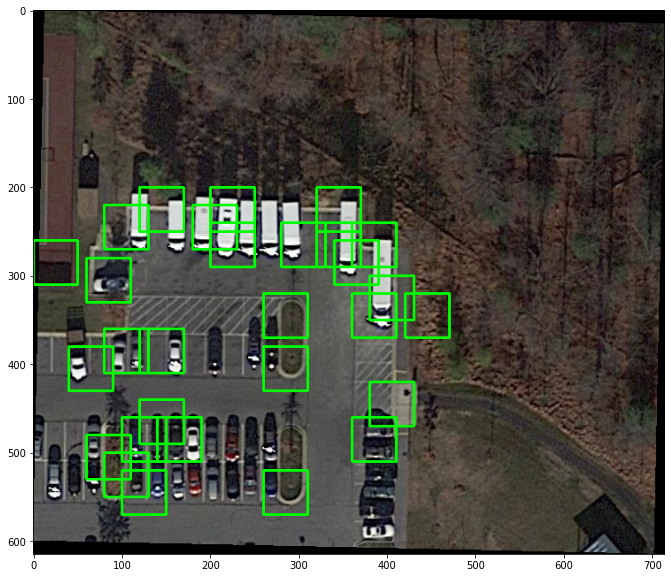

In [55]:
plt.figure(figsize=(20,10))
plt.imshow(processed_images[1][0])

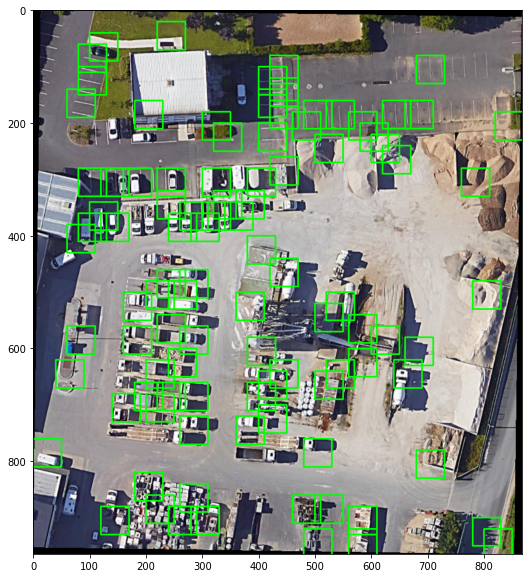

In [56]:
plt.figure(figsize=(20,10))
plt.imshow(processed_images[2][0])

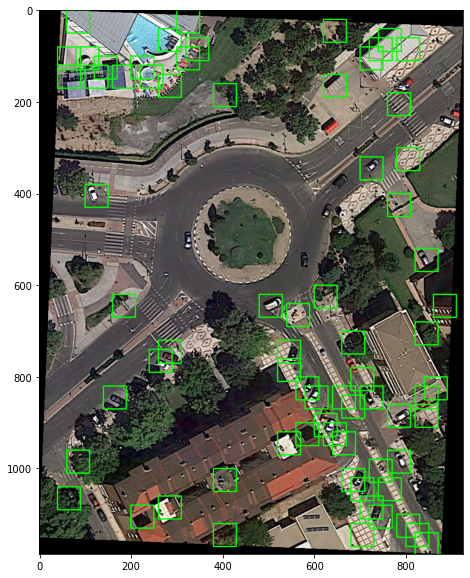

In [57]:
plt.figure(figsize=(20,10))
plt.imshow(processed_images[3][0])

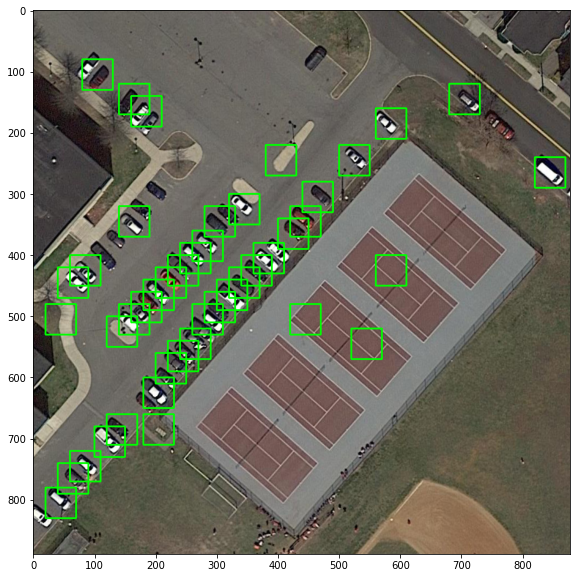

In [58]:
plt.figure(figsize=(20,10))
plt.imshow(processed_images[4][0])